In [1]:
import numpy as np  
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_context("poster")
sns.set_style("whitegrid")
%config InlineBackend.figure_format='retina'
import pymc as pm
import arviz as az

np.set_printoptions(formatter={'float': lambda x: "{0:0.1f}%".format(x)})

## 1.

**Why does computing the mean give you the conversion rate?**

In the example below:

In [2]:
a = stats.bernoulli(p=.1)
b = stats.bernoulli(p=.15)

a_conversions = a.rvs(100)
b_conversions = b.rvs(100)

Computing the mean gives us the conversion rate because `a_conversions` and `b_conversions` are just arrays of 1s and 0s, where 1 indicates a conversion and 0 indicates no conversion. Therefore, running `np.mean(a_conversions)` is asking "what proportion of users were converted?"

In [3]:
a_conversions[:10]

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0])

In [4]:
b_conversions[:10]

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0])

In [5]:
np.mean(a_conversions)

0.11

## 2.

**Come up with 1 other example where just a having the single, most plausible solution, is not enough to make a decision.**

Another example I can think of is estimating support for a political candidate. For example, it's possible that the most plausible value for a candidate could be something like 60%, but range from 40% - 70%:

<AxesSubplot:ylabel='Density'>

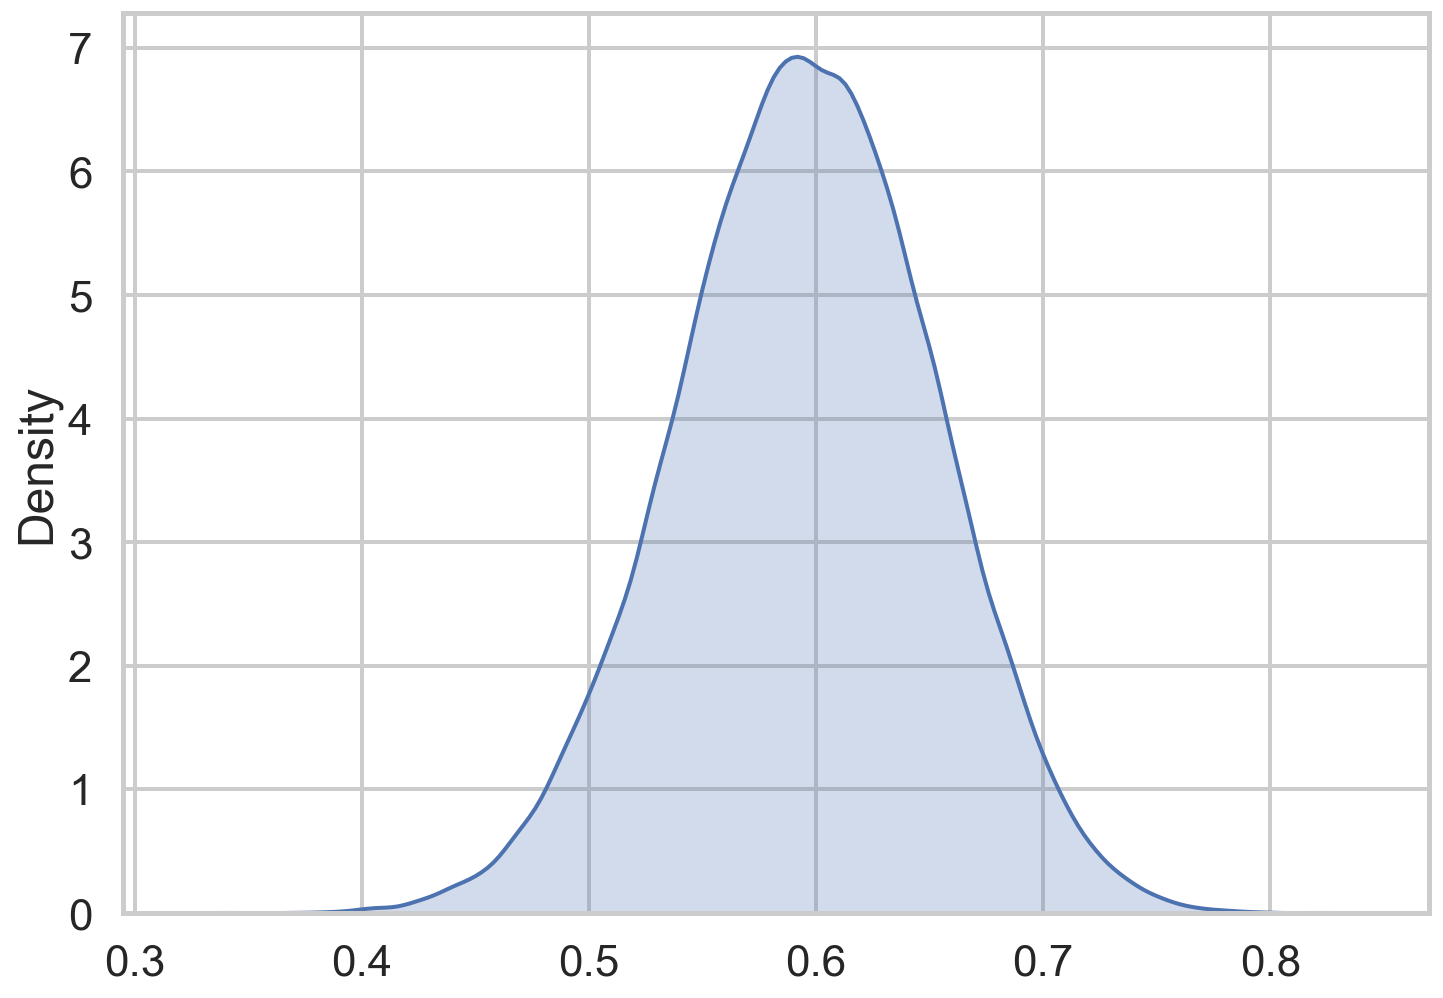

In [27]:
# Generate an example prior distribution for this hypothetical candidate's level of support
support_for_candidate = stats.beta.rvs(44, 30, size=100_000)
sns.kdeplot(support_for_candidate, fill=True)

If we want to calculate the mean support for this candidate, that's pretty easy to do:

In [30]:
def calculate_mean_beta_prior(alpha, beta):
    return alpha / (alpha + beta)

calculate_mean_beta_prior(44, 30)

0.5945945945945946

In [31]:
# I think np.mean() would also be fine in this case
np.mean(support_for_candidate)

0.5947751732170008

While 59.47% is computed correctly, this doesn't tell us the distribution of possible values for a candidate's support. This could make a decision such as figuring out where to spend money on advertisements in areas where the candidate's support is low harder since we only have a point estimate to go off of.

## 3.

**Come up with 1 other question that you could inquire the posterior about.**

One other question we could use the posterior with is constructing a 95% credible interval, which tells where the bulk of the values lie in the distribution.

In [52]:
with pm.Model() as conversion_a_model:
    conversion_rate = pm.Beta('conversion_rate', alpha=2, beta=10)
    likelihood = pm.Bernoulli('likelihood', p=conversion_rate, observed=a_conversions)
    idata_a = pm.sample(draws=10_000, tune=10_000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [conversion_rate]


Sampling 4 chains for 10_000 tune and 10_000 draw iterations (40_000 + 40_000 draws total) took 10 seconds.


<AxesSubplot:title={'center':'conversion_rate'}>

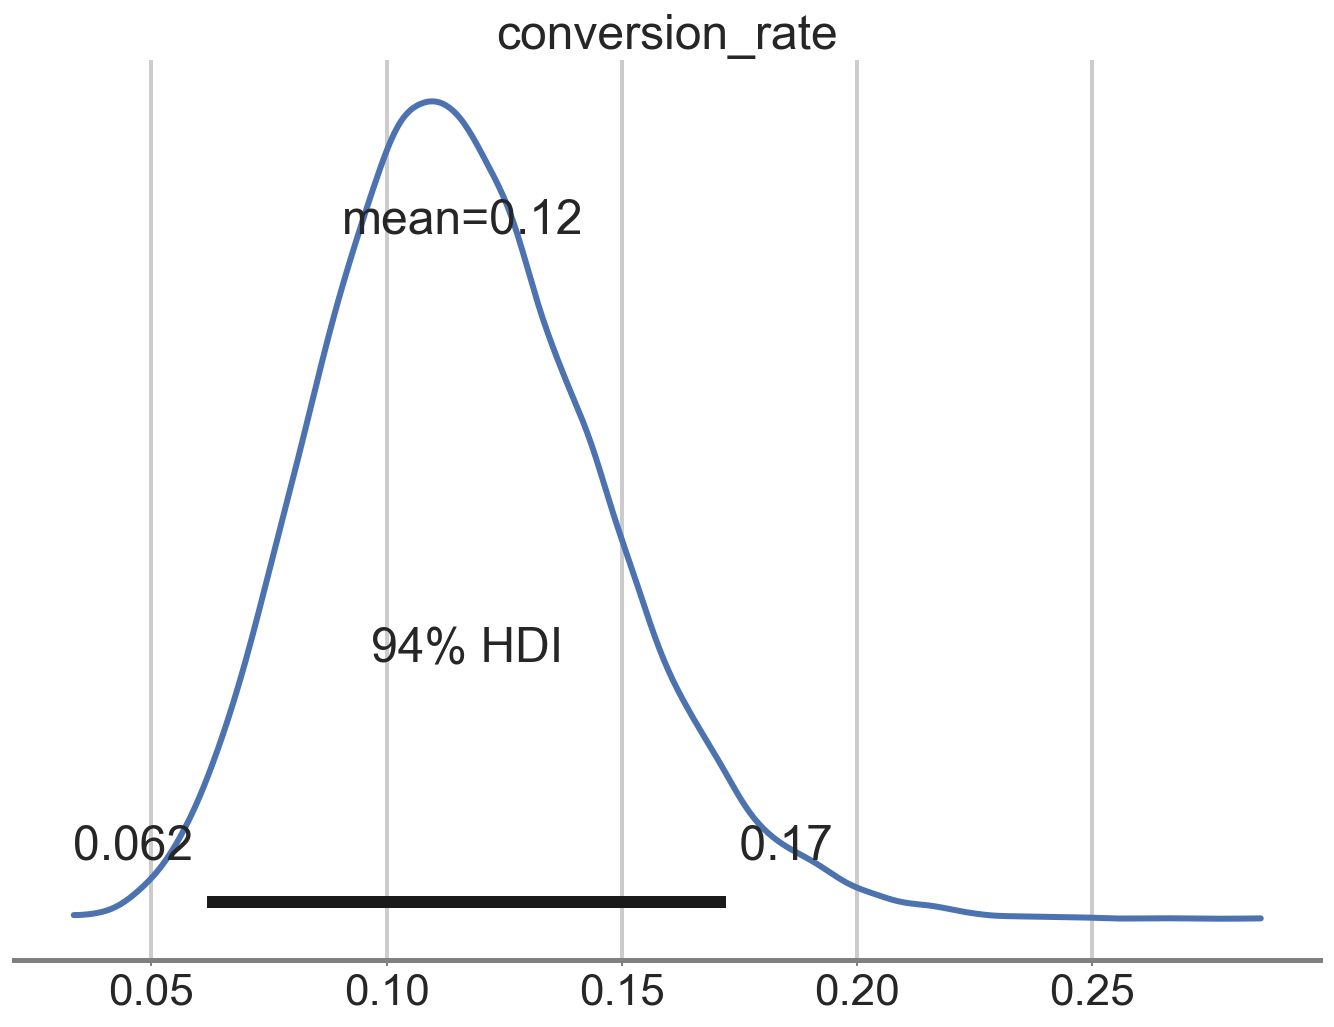

In [53]:
pm.plot_posterior(idata_a, var_names=['conversion_rate'])

So above, we can say that we are 94% confident that the conversion rate for site A is between [0.063, 0.17].

## 4.

**Imagine you have a second posterior for version B of the website, how might you decide which version of the two websites is better?**

I would look at the posterior distributions for each website and see what plausible values are in each posterior. If one of them seems to have a range with higher values (and those higher values are fairly plausible), I'd choose that one. In our case, it doesn't seem that there is really any difference between each site:

In [50]:
with pm.Model() as conversion_b_model:
    conversion_rate = pm.Beta('conversion_rate', alpha=2, beta=10)
    likelihood = pm.Bernoulli("likelihood", p=conversion_rate, observed=b_conversions)
    idata_b = pm.sample(draws=10_000, tune=10_000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [conversion_rate]


Sampling 4 chains for 10_000 tune and 10_000 draw iterations (40_000 + 40_000 draws total) took 10 seconds.


<AxesSubplot:title={'center':'conversion_rate'}>

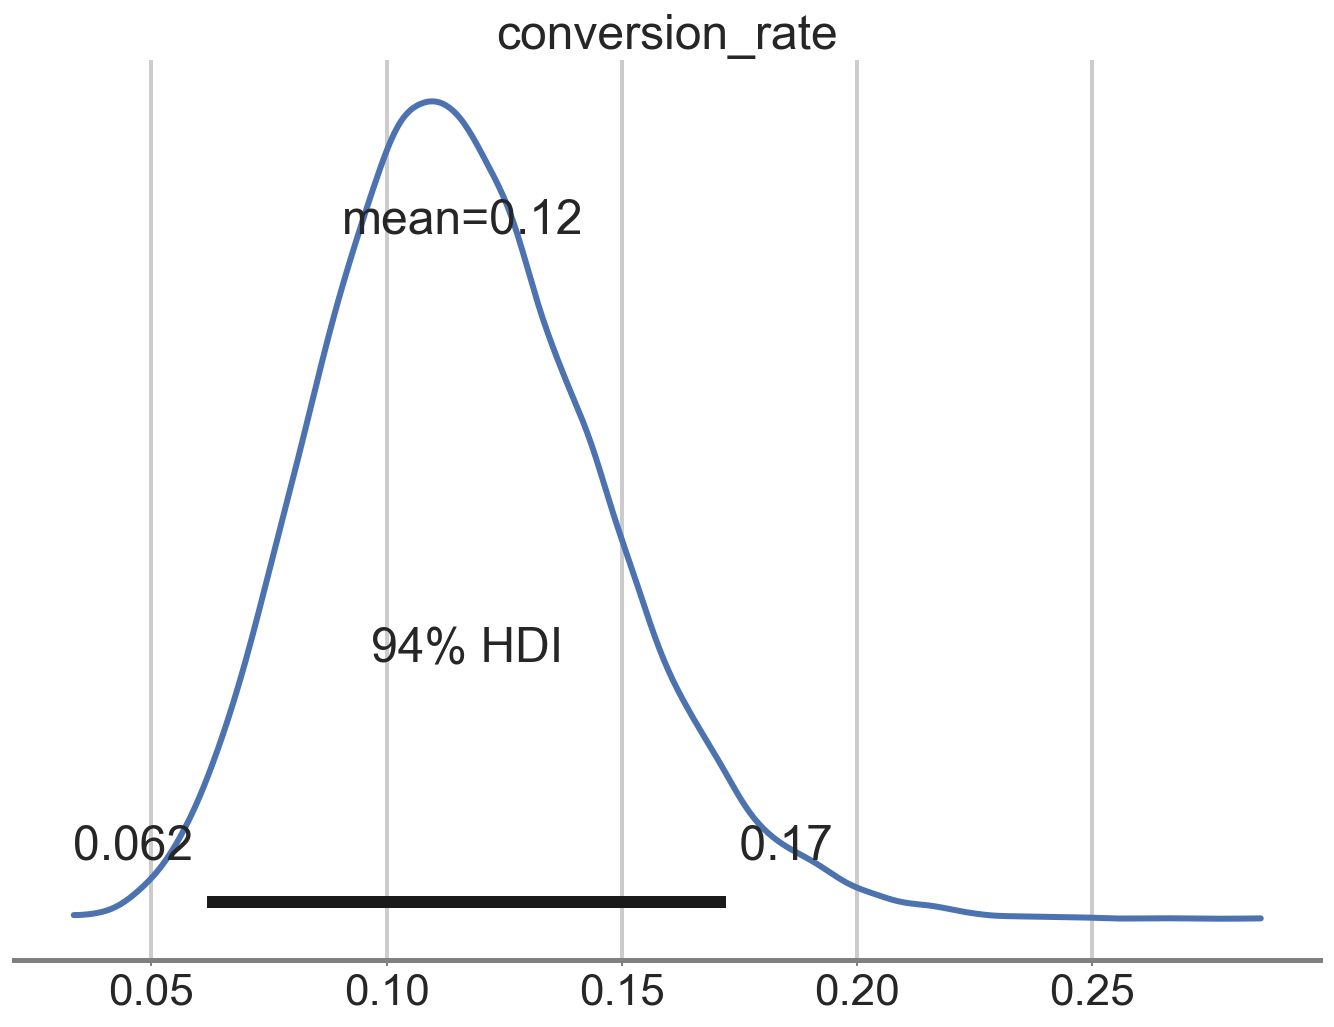

In [54]:
pm.plot_posterior(idata_a, var_names=['conversion_rate'])

<AxesSubplot:title={'center':'conversion_rate'}>

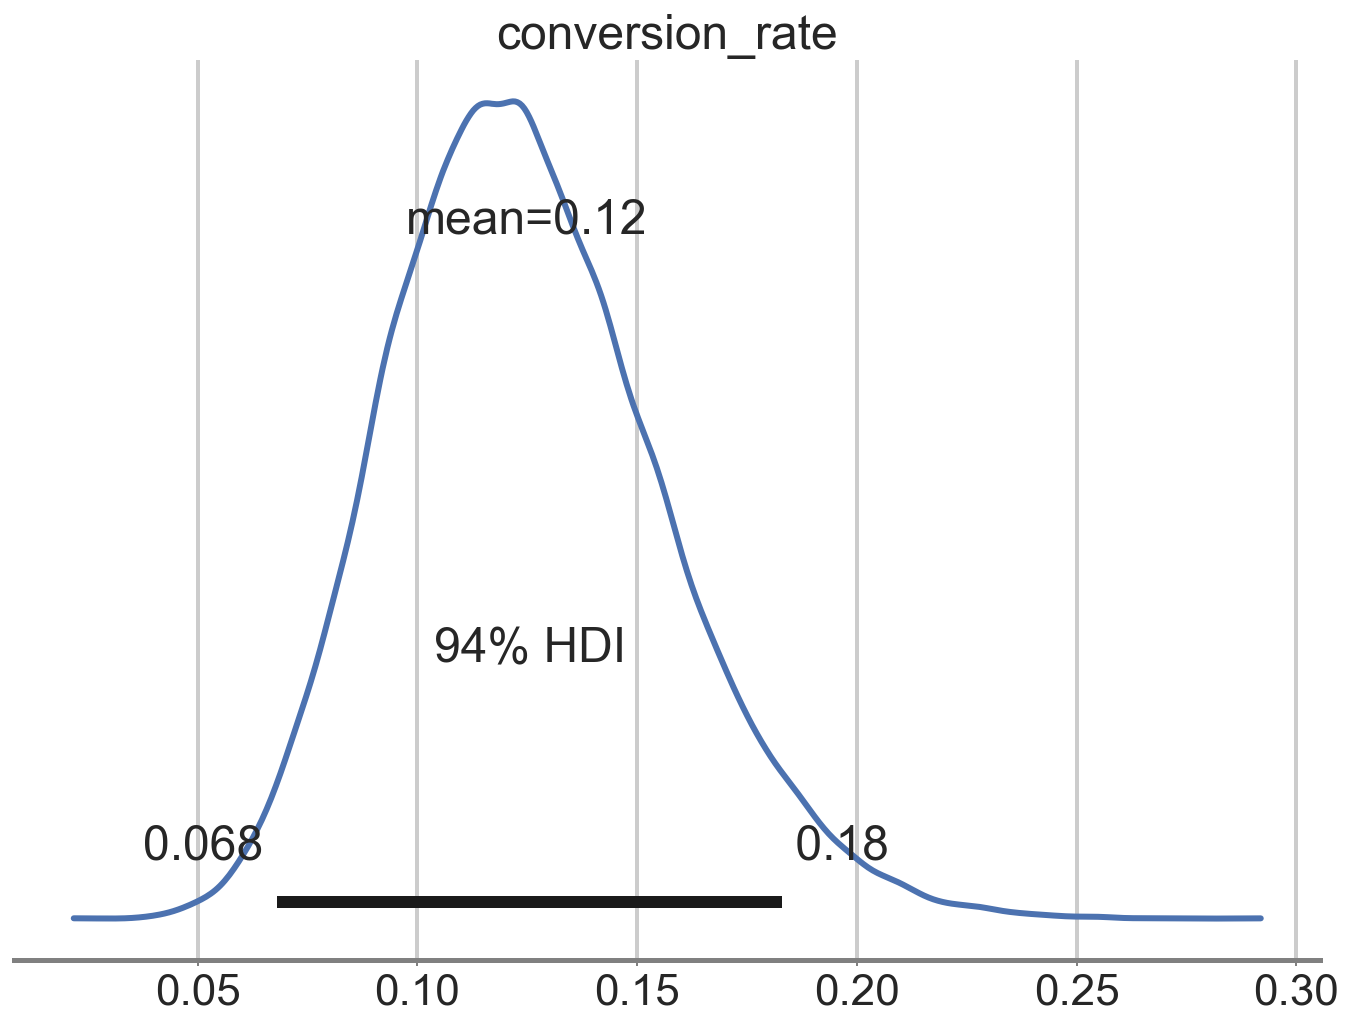

In [51]:
pm.plot_posterior(idata_b, var_names=["conversion_rate"])

## 5.

**Come with another real world example of where you yourself are doing Bayesian learning in daily life.**

A real world example of where I do Bayesian learning in daily life is when I try and figure out when I am going to hang out with my boyfriend. My prior is that I will usually hang out with him on a given day ranges from 60% - 80%. However, on days I know he's super busy with school or work, I adjust that to the left side of the distribution.

## 6. 

**What are the two types of samples introduced in this lesson? How are they the same? How are the different? Share your ideas in the discord channel. Spoilers, we'll dive deeper into this idea in one of the upcoming lessons there's no wrong answers.**

The two types of samples introduced in this lesson are priors and likelihood (i.e. our observed data). They're the same as both try to estimate the underlying data generating process of the outcome we're interested in. However, our priors are built with plausible values *before* seeing the data. I think of this as our beliefs encoded as probability distribution of some parameter of interest. The likelihood, on the other hand, represents the distribution of our observed data, which can differ from the plausible values in our prior.